In [8]:
#Initialization

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt


In [23]:
import fix_yahoo_finance as yf  

Stocks = ['AAPL', 'FB','GOOGL','AMZN']
data = yf.download(Stocks,'2016-01-01','2018-06-01')


[*********************100%***********************]  4 of 4 downloaded


In [24]:
data

<class 'pandas.core.panel.Panel'>
Dimensions: 6 (items) x 608 (major_axis) x 4 (minor_axis)
Items axis: Open to Volume
Major_axis axis: 2016-01-04 00:00:00 to 2018-06-01 00:00:00
Minor_axis axis: AAPL to GOOGL

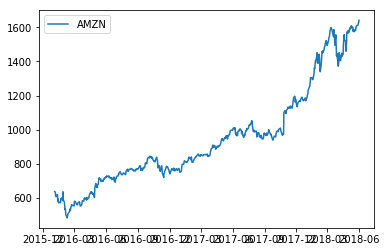

In [25]:
St = data['Adj Close']['AMZN']
plt.plot(St)
plt.legend(['AMZN'])
plt.show()

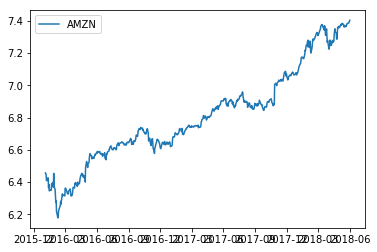

In [109]:
# Take the log price
LogSt = np.log(St)
plt.plot(LogSt)
plt.legend(['AMZN'])
plt.show()

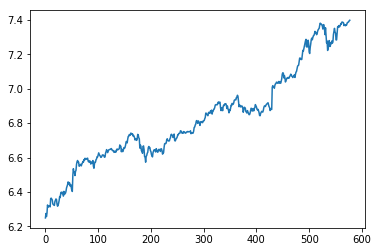

In [110]:
N_day = 30


T = len(LogSt)
S_nd = np.zeros(T-N_day)
for t in range(N_day-1,T-1):
    S_nd[t-N_day+1] = (LogSt[t] - LogSt[t-N_day+1])/(N_day-1) + LogSt[t]
plt.plot(S_nd)
plt.show()

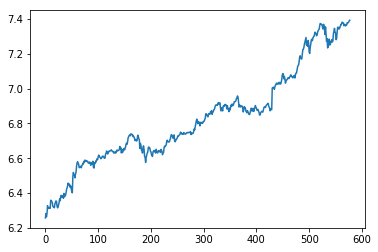

In [111]:
S_ou = np.zeros(T-N_day)
for t in range(N_day-1,T-1):
    train = np.array(LogSt[t-N_day+1:t])
    #fit linear regression
    y = train[1:] - train[:-1]
    x = train[:-1]
    param = np.polyfit(x,y,1)
    beta = -param[0]
    mu = param[1]/beta
    dx = beta*(mu - train[-1])
    S_ou[t-N_day+1] = LogSt[t] + dx

plt.plot(S_ou)
plt.show()

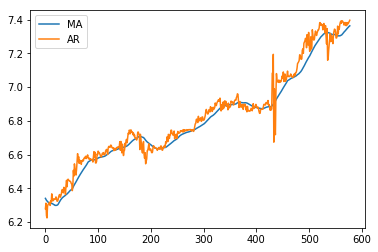

In [112]:
import statsmodels.tsa.ar_model as ARM
import warnings



warnings.simplefilter("ignore")


X=pd.Series(LogSt)


# Moving average 
MA=X.rolling(window=N_day+1,center=False).mean()
MA.columns=['MA']

# AutoRegression


AR = pd.Series([['NaN']]*N_day)
AR.index=X.index[0:N_day]
for i in range(len(X)-N_day):
    train=X[i:i+N_day]
    test=X[N_day]
    model = ARM.AR(train)
    model_fit = model.fit()
    s=pd.Series(model_fit.predict(start=len(train),end=len(train)))
    s.columns=['AR']
    s.index=X.index[i+N_day:i+N_day+1]
    AR=AR.append(s)
    
#AR=pd.Series(AR)    
S_ma = np.array(MA[N_day:])
S_ar = np.array(AR[N_day:])
plt.plot(S_ma)
plt.plot(S_ar)
plt.legend(['MA','AR'])
plt.show()

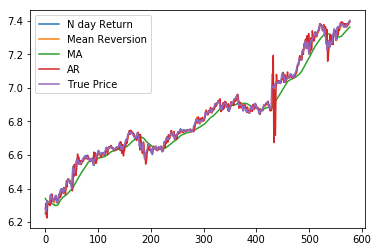

In [113]:
plt.plot(S_nd)
plt.plot(S_ou)
plt.plot(S_ma)
plt.plot(S_ar)
plt.plot(np.array(LogSt[N_day:]))
plt.legend(['N day Return', 'Mean Reversion','MA','AR', 'True Price'])
plt.show()

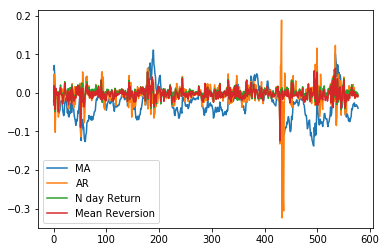

In [116]:
plt.plot(S_ma-np.array(LogSt[N_day:]))
plt.plot(S_ar-np.array(LogSt[N_day:]))
plt.plot(S_nd-np.array(LogSt[N_day:]))
plt.plot(S_ou-np.array(LogSt[N_day:]))
plt.legend(['MA','AR','N day Return', 'Mean Reversion'])
plt.show()

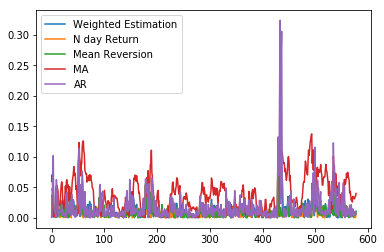

Average regret of Weighted Estimation is 0.000355030599209
Average regret of N day Return is 0.00023210722027
Average regret of Mean Reversion is 0.000241929083269
Average regret of Moving Average is 0.00237965555853
Average regret of AutoRegression is 0.0011239207825293233


In [117]:
WEst = np.zeros(T-N_day)
reg_ar = [0]
reg_ma = [0]
reg_nd = [0]
reg_ou = [0]
w_nd=[]
w_ou=[]
w_ar=[]
w_ma=[]
for t in range(T-N_day):
    w_nd.append(np.exp(-reg_nd[0])/(np.exp(-reg_nd[0]) + np.exp(-reg_ou[0])+np.exp(-reg_ar[0]) + np.exp(-reg_ma[0])))
    w_ou.append(np.exp(-reg_ou[0])/(np.exp(-reg_nd[0]) + np.exp(-reg_ou[0])+np.exp(-reg_ar[0]) + np.exp(-reg_ma[0])))
    w_ar.append(np.exp(-reg_ar[0])/(np.exp(-reg_nd[0]) + np.exp(-reg_ou[0])+np.exp(-reg_ar[0]) + np.exp(-reg_ma[0])))
    w_ma.append(np.exp(-reg_ma[0])/(np.exp(-reg_nd[0]) + np.exp(-reg_ou[0])+np.exp(-reg_ar[0]) + np.exp(-reg_ma[0])))
    WEst[t] = w_nd[t]*S_nd[t] + w_ou[t]*S_ou[t]+w_ar[t]*S_ar[t] + w_ma[t]*S_ma[t]
    #use square loss as the regret
    reg_nd += (S_nd[t] - X[t+N_day])**2
    reg_ou += (S_ou[t] - X[t+N_day])**2
    reg_ar += (S_ar[t] - X[t+N_day])**2
    reg_ma += (S_ma[t] - X[t+N_day])**2

plt.plot(abs(WEst-np.array(X[N_day:])))
plt.plot(abs(S_nd-np.array(X[N_day:])))
plt.plot(abs(S_ou-np.array(X[N_day:])))
plt.plot(abs(S_ma-np.array(X[N_day:])))
plt.plot(abs(S_ar-np.array(X[N_day:])))
plt.legend(['Weighted Estimation', 'N day Return', 'Mean Reversion','MA','AR'])
plt.show()
print('Average regret of Weighted Estimation is',np.mean(np.power(WEst-np.array(X[N_day:]),2)))
print('Average regret of N day Return is',np.mean(np.power(S_nd-np.array(X[N_day:]),2)))
print('Average regret of Mean Reversion is',np.mean(np.power(S_ou-np.array(X[N_day:]),2)))
print('Average regret of Moving Average is',np.mean(np.power(S_ma-np.array(X[N_day:]),2)))
print('Average regret of AutoRegression is',np.mean(np.power(S_ar-np.array(X[N_day:]),2)))

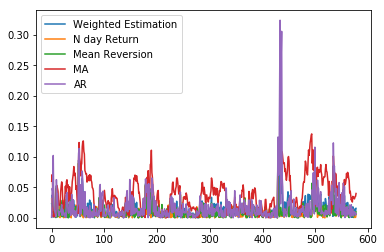

Average regret of Weighted Estimation is [-110.7440063]
Average regret of N day Return is [-110.7440063]
Average regret of Mean Reversion is [-110.7440063]
Average regret of Moving Average is [-110.7440063]
Average regret of AutoRegression is [-110.7440063]


In [123]:
WEst = np.zeros(T-N_day)
reg_ar = [0]
reg_ma = [0]
reg_nd = [0]
reg_ou = [0]
reg_we = [0]
w_nd=[]
w_ou=[]
w_ar=[]
w_ma=[]
for t in range(T-N_day):
    w_nd.append(np.exp(-reg_nd[0])/(np.exp(-reg_nd[0]) + np.exp(-reg_ou[0])+np.exp(-reg_ar[0]) + np.exp(-reg_ma[0])))
    w_ou.append(np.exp(-reg_ou[0])/(np.exp(-reg_nd[0]) + np.exp(-reg_ou[0])+np.exp(-reg_ar[0]) + np.exp(-reg_ma[0])))
    w_ar.append(np.exp(-reg_ar[0])/(np.exp(-reg_nd[0]) + np.exp(-reg_ou[0])+np.exp(-reg_ar[0]) + np.exp(-reg_ma[0])))
    w_ma.append(np.exp(-reg_ma[0])/(np.exp(-reg_nd[0]) + np.exp(-reg_ou[0])+np.exp(-reg_ar[0]) + np.exp(-reg_ma[0])))
    WEst[t] = w_nd[t]*S_nd[t] + w_ou[t]*S_ou[t]+w_ar[t]*S_ar[t] + w_ma[t]*S_ma[t]
    #use square loss as the regret
    if t < T-N_day-1:
        reg_nd += -np.sign(S_nd[t])*(St[t+N_day+1]-St[t+N_day])/10
        reg_ou += -np.sign(S_ou[t])*(St[t+N_day+1]-St[t+N_day])/10
        reg_ar += -np.sign(S_ar[t])*(St[t+N_day+1]-St[t+N_day])/10
        reg_ma += -np.sign(S_ma[t])*(St[t+N_day+1]-St[t+N_day])/10
        reg_we += -np.sign(WEst[t])*(St[t+N_day+1]-St[t+N_day])/10

plt.plot(abs(WEst-np.array(X[N_day:])))
plt.plot(abs(S_nd-np.array(X[N_day:])))
plt.plot(abs(S_ou-np.array(X[N_day:])))
plt.plot(abs(S_ma-np.array(X[N_day:])))
plt.plot(abs(S_ar-np.array(X[N_day:])))
plt.legend(['Weighted Estimation', 'N day Return', 'Mean Reversion','MA','AR'])
plt.show()
print('Average regret of Weighted Estimation is',reg_we)
print('Average regret of N day Return is',reg_nd)
print('Average regret of Mean Reversion is',reg_ou)
print('Average regret of Moving Average is',reg_ma)
print('Average regret of AutoRegression is',reg_ar)

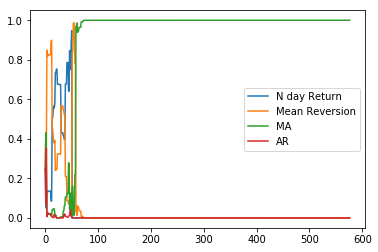

In [108]:
plt.plot(w_nd)
plt.plot(w_ou)
plt.plot(w_ma)
plt.plot(w_ar)
plt.legend(['N day Return', 'Mean Reversion','MA','AR'])
plt.show()